In [2]:
import pandas as pd
import numpy as np
import math

#Visualizing
import matplotlib.pyplot as plt
plt.rcParams['font.family'] = 'Malgun Gothic'; plt.rcParams['axes.unicode_minus'] = False;
import seaborn as sns; #sns.set_style('whitegrid')

#Time Series Analysis
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller, kpss, ccf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

#Clustering (+α)
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from tslearn.clustering import TimeSeriesKMeans, silhouette_score
from minisom import MiniSom

#Modeling
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense, Dropout
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error

#System
from ipywidgets import interact
from tqdm.notebook import tqdm
import warnings
warnings.filterwarnings('ignore')


In [3]:
%matplotlib inline

In [40]:
data = pd.read_excel('아파트매매가격지수_경기도_10년.xlsx')
#Importing the dataset
dataset = pd.read_excel('아파트매매가격지수_경기도_10년.xlsx',index_col = 0)
#data = dataset.drop('행정구역별',axis = 1)
#data
dataset

,2013-01-01,2013-02-01,2013-03-01,2013-04-01,2013-05-01,2013-06-01,2013-07-01,2013-08-01,2013-09-01,2013-10-01,...,2021-05-01,2021-06-01,2021-07-01,2021-08-01,2021-09-01,2021-10-01,2021-11-01,2021-12-01,2022-01-01,2022-02-01
행정구역별,,,,,,,,,,,,,,,,,,,,,
수원시,63.4,63.3,63.2,63.3,63.4,63.5,63.4,63.2,63.2,63.4,...,97.3,100,102.4,104.7,106.5,108.4,109.5,109.8,109.8,109.6
성남시,67.8,67.2,66.9,67.1,67.5,67.9,67.7,67.4,67.4,67.5,...,99.1,100,101.3,102.6,103.6,104.3,104.8,105.1,105.1,105.0
의정부시,77.7,77.4,76.9,76.4,76.4,76.2,75.5,75.2,75.1,75.2,...,97.2,100,101.8,103.8,105.2,106.5,107.2,107.4,107.4,107.3
안양시,60.5,60.2,60.0,59.8,59.6,59.5,59.5,59.4,59.5,59.8,...,95.2,100,103.2,106.2,108.3,110.5,111.7,112.0,111.8,111.6
부천시,68.1,67.7,67.4,67.4,67.6,67.6,67.5,67.2,67.2,67.8,...,97.2,100,102.0,104.5,106.7,108.7,110.2,110.8,110.8,110.7
광명시,53.0,52.9,52.6,52.6,52.9,53.0,53.1,52.9,53.1,53.1,...,98.4,100,102.0,104.0,105.5,106.7,107.3,107.4,107.3,107.3
평택시,92.6,92.5,92.4,92.4,92.4,92.6,92.5,92.3,92.3,92.4,...,95.2,100,103.0,106.2,108.8,111.7,113.2,114.1,114.3,114.3
동두천시,92.6,90.9,90.1,90.0,89.8,89.6,89.3,89.0,88.9,89.0,...,97.2,100,102.0,104.5,106.4,107.3,107.7,107.5,107.5,107.4
안산시,66.8,66.6,66.3,66.3,66.6,66.8,66.7,66.5,66.6,66.9,...,95.0,100,102.8,105.0,107.1,109.3,110.7,111.2,111.3,111.3


In [17]:
# 클러스터 돌리기 전 변수를 생성 
df = dataset.copy()


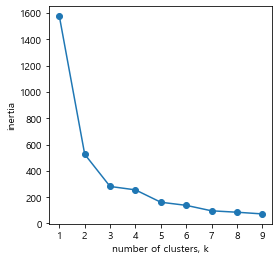

In [18]:
# 적절한 군집수 찾기 
# Inertia(군집 내 거리제곱합의 합) value (적정 군집수) 
ks = range(1,10) 
inertias = [] 
for k in ks: 
    model = TimeSeriesKMeans(n_clusters=k, metric="dtw",random_state = 2022)
    model.fit(df) 
    inertias.append(model.inertia_) 
    # Plot ks vs inertias 
plt.figure(figsize=(4, 4)) 
plt.plot(ks, inertias, '-o') 
plt.xlabel('number of clusters, k') 
plt.ylabel('inertia') 
plt.xticks(ks) 
plt.show()



In [19]:
import numpy as np
from sklearn.metrics import silhouette_samples
from sklearn.datasets import make_blobs
from matplotlib import cm

def plotSilhouette(X, y_km):
    cluster_labels = np.unique(y_km)
    n_clusters = cluster_labels.shape[0]
    silhouette_vals = silhouette_samples(X, y_km, metric = 'euclidean')
    y_ax_lower, y_ax_upper = 0, 0
    yticks = []

    for i, c in enumerate(cluster_labels):
        c_silhouette_vals = silhouette_vals[y_km == c]
        c_silhouette_vals.sort()
        y_ax_upper += len(c_silhouette_vals)
        color = cm.jet(i/n_clusters)

        plt.barh(range(y_ax_lower, y_ax_upper), c_silhouette_vals, height=1.0,
                edgecolor='none', color=color)
        yticks.append((y_ax_lower + y_ax_upper)/2)
        y_ax_lower += len(c_silhouette_vals)

    silhoutte_avg = np.mean(silhouette_vals)
    plt.axvline(silhoutte_avg, color = 'red', linestyle='--')
    plt.yticks(yticks, cluster_labels+1)
    plt.ylabel('K')
    plt.xlabel('실루엣 계수')
    plt.show()


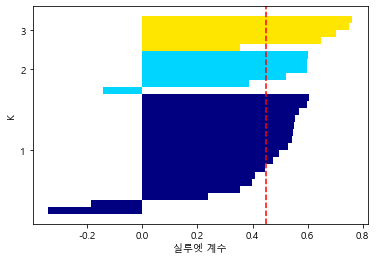

In [20]:
k= 3

X, y = make_blobs(n_samples=150, n_features=2, centers=3, cluster_std=0.5,
                  shuffle=True, random_state=0)
km = TimeSeriesKMeans(n_clusters=k, metric="dtw",random_state = 2022)
y_km = km.fit_predict(df)
plotSilhouette(df, y_km)

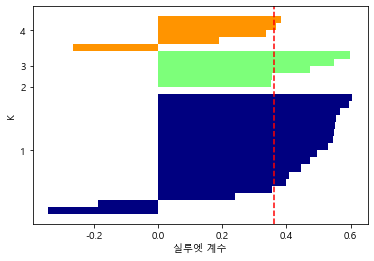

In [21]:
k= 4

X, y = make_blobs(n_samples=150, n_features=2, centers=3, cluster_std=0.5,
                  shuffle=True, random_state=0)
km = TimeSeriesKMeans(n_clusters=k, metric="dtw",random_state = 2022)
y_km = km.fit_predict(df)
plotSilhouette(df, y_km)

In [22]:
# K-Means 모델과 군집 예측값을 생성 
# 클러스터 모델 생성 파라미터는 원할 경우 추가 
model =  TimeSeriesKMeans(n_clusters=3, metric="dtw", random_state = 2022)
                     # 클러스터 갯수 
                     # , n_init=10 
                     # initial centroid를 몇번 샘플링한건지, 데이터가 많으면 많이 돌릴수록안정화된 결과가 나옴 
                     # , max_iter=500 # KMeans를 몇번 반복 수행할건지, K가 큰 경우 1000정도로 높여준다 
                     #random_state = 42 # , algorithm='auto' ) 
 # 생성한 모델로 데이터를 학습시킴 
model.fit(df) # unsupervised learning 
# 결과 값을 변수에 저장 
df['cluster'] = model.fit_predict(df)

In [23]:
df

,2013-01-01 00:00:00,2013-02-01 00:00:00,2013-03-01 00:00:00,2013-04-01 00:00:00,2013-05-01 00:00:00,2013-06-01 00:00:00,2013-07-01 00:00:00,2013-08-01 00:00:00,2013-09-01 00:00:00,2013-10-01 00:00:00,...,2021-06-01 00:00:00,2021-07-01 00:00:00,2021-08-01 00:00:00,2021-09-01 00:00:00,2021-10-01 00:00:00,2021-11-01 00:00:00,2021-12-01 00:00:00,2022-01-01 00:00:00,2022-02-01 00:00:00,cluster
행정구역별,,,,,,,,,,,,,,,,,,,,,
수원시,63.4,63.3,63.2,63.3,63.4,63.5,63.4,63.2,63.2,63.4,...,100,102.4,104.7,106.5,108.4,109.5,109.8,109.8,109.6,0
성남시,67.8,67.2,66.9,67.1,67.5,67.9,67.7,67.4,67.4,67.5,...,100,101.3,102.6,103.6,104.3,104.8,105.1,105.1,105.0,0
의정부시,77.7,77.4,76.9,76.4,76.4,76.2,75.5,75.2,75.1,75.2,...,100,101.8,103.8,105.2,106.5,107.2,107.4,107.4,107.3,2
안양시,60.5,60.2,60.0,59.8,59.6,59.5,59.5,59.4,59.5,59.8,...,100,103.2,106.2,108.3,110.5,111.7,112.0,111.8,111.6,0
부천시,68.1,67.7,67.4,67.4,67.6,67.6,67.5,67.2,67.2,67.8,...,100,102.0,104.5,106.7,108.7,110.2,110.8,110.8,110.7,0
광명시,53.0,52.9,52.6,52.6,52.9,53.0,53.1,52.9,53.1,53.1,...,100,102.0,104.0,105.5,106.7,107.3,107.4,107.3,107.3,0
평택시,92.6,92.5,92.4,92.4,92.4,92.6,92.5,92.3,92.3,92.4,...,100,103.0,106.2,108.8,111.7,113.2,114.1,114.3,114.3,1
동두천시,92.6,90.9,90.1,90.0,89.8,89.6,89.3,89.0,88.9,89.0,...,100,102.0,104.5,106.4,107.3,107.7,107.5,107.5,107.4,1
안산시,66.8,66.6,66.3,66.3,66.6,66.8,66.7,66.5,66.6,66.9,...,100,102.8,105.0,107.1,109.3,110.7,111.2,111.3,111.3,0


In [45]:
df.loc[df['cluster'] == 1]

,2013-01-01 00:00:00,2013-02-01 00:00:00,2013-03-01 00:00:00,2013-04-01 00:00:00,2013-05-01 00:00:00,2013-06-01 00:00:00,2013-07-01 00:00:00,2013-08-01 00:00:00,2013-09-01 00:00:00,2013-10-01 00:00:00,...,2021-06-01 00:00:00,2021-07-01 00:00:00,2021-08-01 00:00:00,2021-09-01 00:00:00,2021-10-01 00:00:00,2021-11-01 00:00:00,2021-12-01 00:00:00,2022-01-01 00:00:00,2022-02-01 00:00:00,cluster
행정구역별,,,,,,,,,,,,,,,,,,,,,
평택시,92.6,92.5,92.4,92.4,92.4,92.6,92.5,92.3,92.3,92.4,...,100,103.0,106.2,108.8,111.7,113.2,114.1,114.3,114.3,1
동두천시,92.6,90.9,90.1,90.0,89.8,89.6,89.3,89.0,88.9,89.0,...,100,102.0,104.5,106.4,107.3,107.7,107.5,107.5,107.4,1
이천시,89.2,89.4,89.7,90.1,90.4,90.6,90.7,90.8,91.0,91.5,...,100,101.6,103.3,105.3,107.8,110.3,112.3,113.3,114.2,1
안성시,92.6,92.8,92.8,93.5,93.8,94.1,94.3,94.4,94.7,95.3,...,100,103.7,106.9,109.9,112.6,114.8,116.1,116.9,117.0,1
여주시,102.8,102.8,102.7,102.7,103.6,103.8,103.9,103.8,103.8,104.3,...,100,101.1,102.4,103.5,105.2,106.6,107.2,107.1,107.1,1
포천시,93.6,93.6,93.6,93.9,94.7,95.1,94.7,94.2,93.8,94.1,...,100,101.6,103.7,105.8,107.3,108.4,109.0,109.2,109.3,1


In [46]:
df.loc[df['cluster'] == 1].index

Index(['평택시', '동두천시', '이천시', '안성시', '여주시', '포천시'], dtype='object', name='행정구역별')